In [2]:
from pprint import pprint as pp

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.ioff()

mpl.rcParams['figure.dpi'] = 500

In [3]:
energies = [-4109.00941469,
            -4100.97162191,
            -4092.63197519,
            -4084.03190795,
            -4075.33034836,
            -4065.91677493,
            -4056.48595094,
            -4047.89409332,
            -4038.56283037,
            -4029.43964490]

We have the energies of $TiO_2$ vs. $VO$

In [4]:
E_vs_VO = {index: energy for index, energy in enumerate(energies)}
pp(E_vs_VO)

{0: -4109.00941469,
 1: -4100.97162191,
 2: -4092.63197519,
 3: -4084.03190795,
 4: -4075.33034836,
 5: -4065.91677493,
 6: -4056.48595094,
 7: -4047.89409332,
 8: -4038.56283037,
 9: -4029.4396449}


We have the bulk energy of $TiO_2$, reference energy for the oxygen molecule, and the total energy of the $(1x2)$ $Ti_2O_3$ surface.
Here, what I don't fully understand is how this reconstruction happens, but I tried to come up with an explanation to my results.
For the surface energies, I used the exact same equation in the slides.

In [5]:
E_recon = -4445.01964141
E_bulk = -23.087792205
E_O = -5.025


def surfen(e_slab, n_ti, n_vo, mu_o, area_coeff):
    s_e = e_slab - n_ti * E_bulk + n_vo * (E_O + mu_o)
    s_e /= area_coeff
    return np.round(s_e, 4)

I used the range for $\Delta\mu_O$ the same range used in the slides, as this range gave me the intersections I was looking for.
For the $(1x2)$ $Ti_2O_3$ reconstruction, I needed to find a way to get $VO$ first. This is how I came up with $VO = 9$ for this specific surface.
There are 180 Ti atoms in the stoichiometric+VO $TiO_2$, and 198 in $(1x2)$ $Ti_2O_3$.
Without the reconstruction, for a stoichiometric unreconstructed surface with 198 Ti atoms, we would have $198*2=396$ O atoms. In the reconstructed version however, we have 18 units of $Ti_2O_3$ and 180 units of $TiO_2$. This amounts to a total of $180*2 + 3*(18/2) = 387$ $O$ atoms. The difference, 9, is the number of $O$ vacancies in the $(1x2)$ $Ti_2O_3$ surface, and that's why I ended up using $VO = 9$ for this reconstruction. To be perfectly honest, I reached this conclusion by looking at the phase diagrams in the slides, and how the reconstruction aligns with $50\% VO$, but after going through the the steps above, I concluded that it makes sense for me.

In [6]:
mu_o_arr = np.linspace(-5, -2.5, 500)
surfens = {}
for n_vo, e_slab in E_vs_VO.items():
    surfens[n_vo] = []
    for mu_o in mu_o_arr:
        surfens[n_vo].append(surfen(e_slab, 180, n_vo, mu_o, 18))

sto_surfen = surfens[0][0]

surfens['recon'] = []
for mu_o in mu_o_arr:
    surfens['recon'].append(surfen(E_recon, 198, 9, mu_o, 18))

surfens['recon'][180] - sto_surfen

-0.14100000000000001

Then we just go through every point in the surface energy array wrt. $\Delta\mu_O$ and plot.

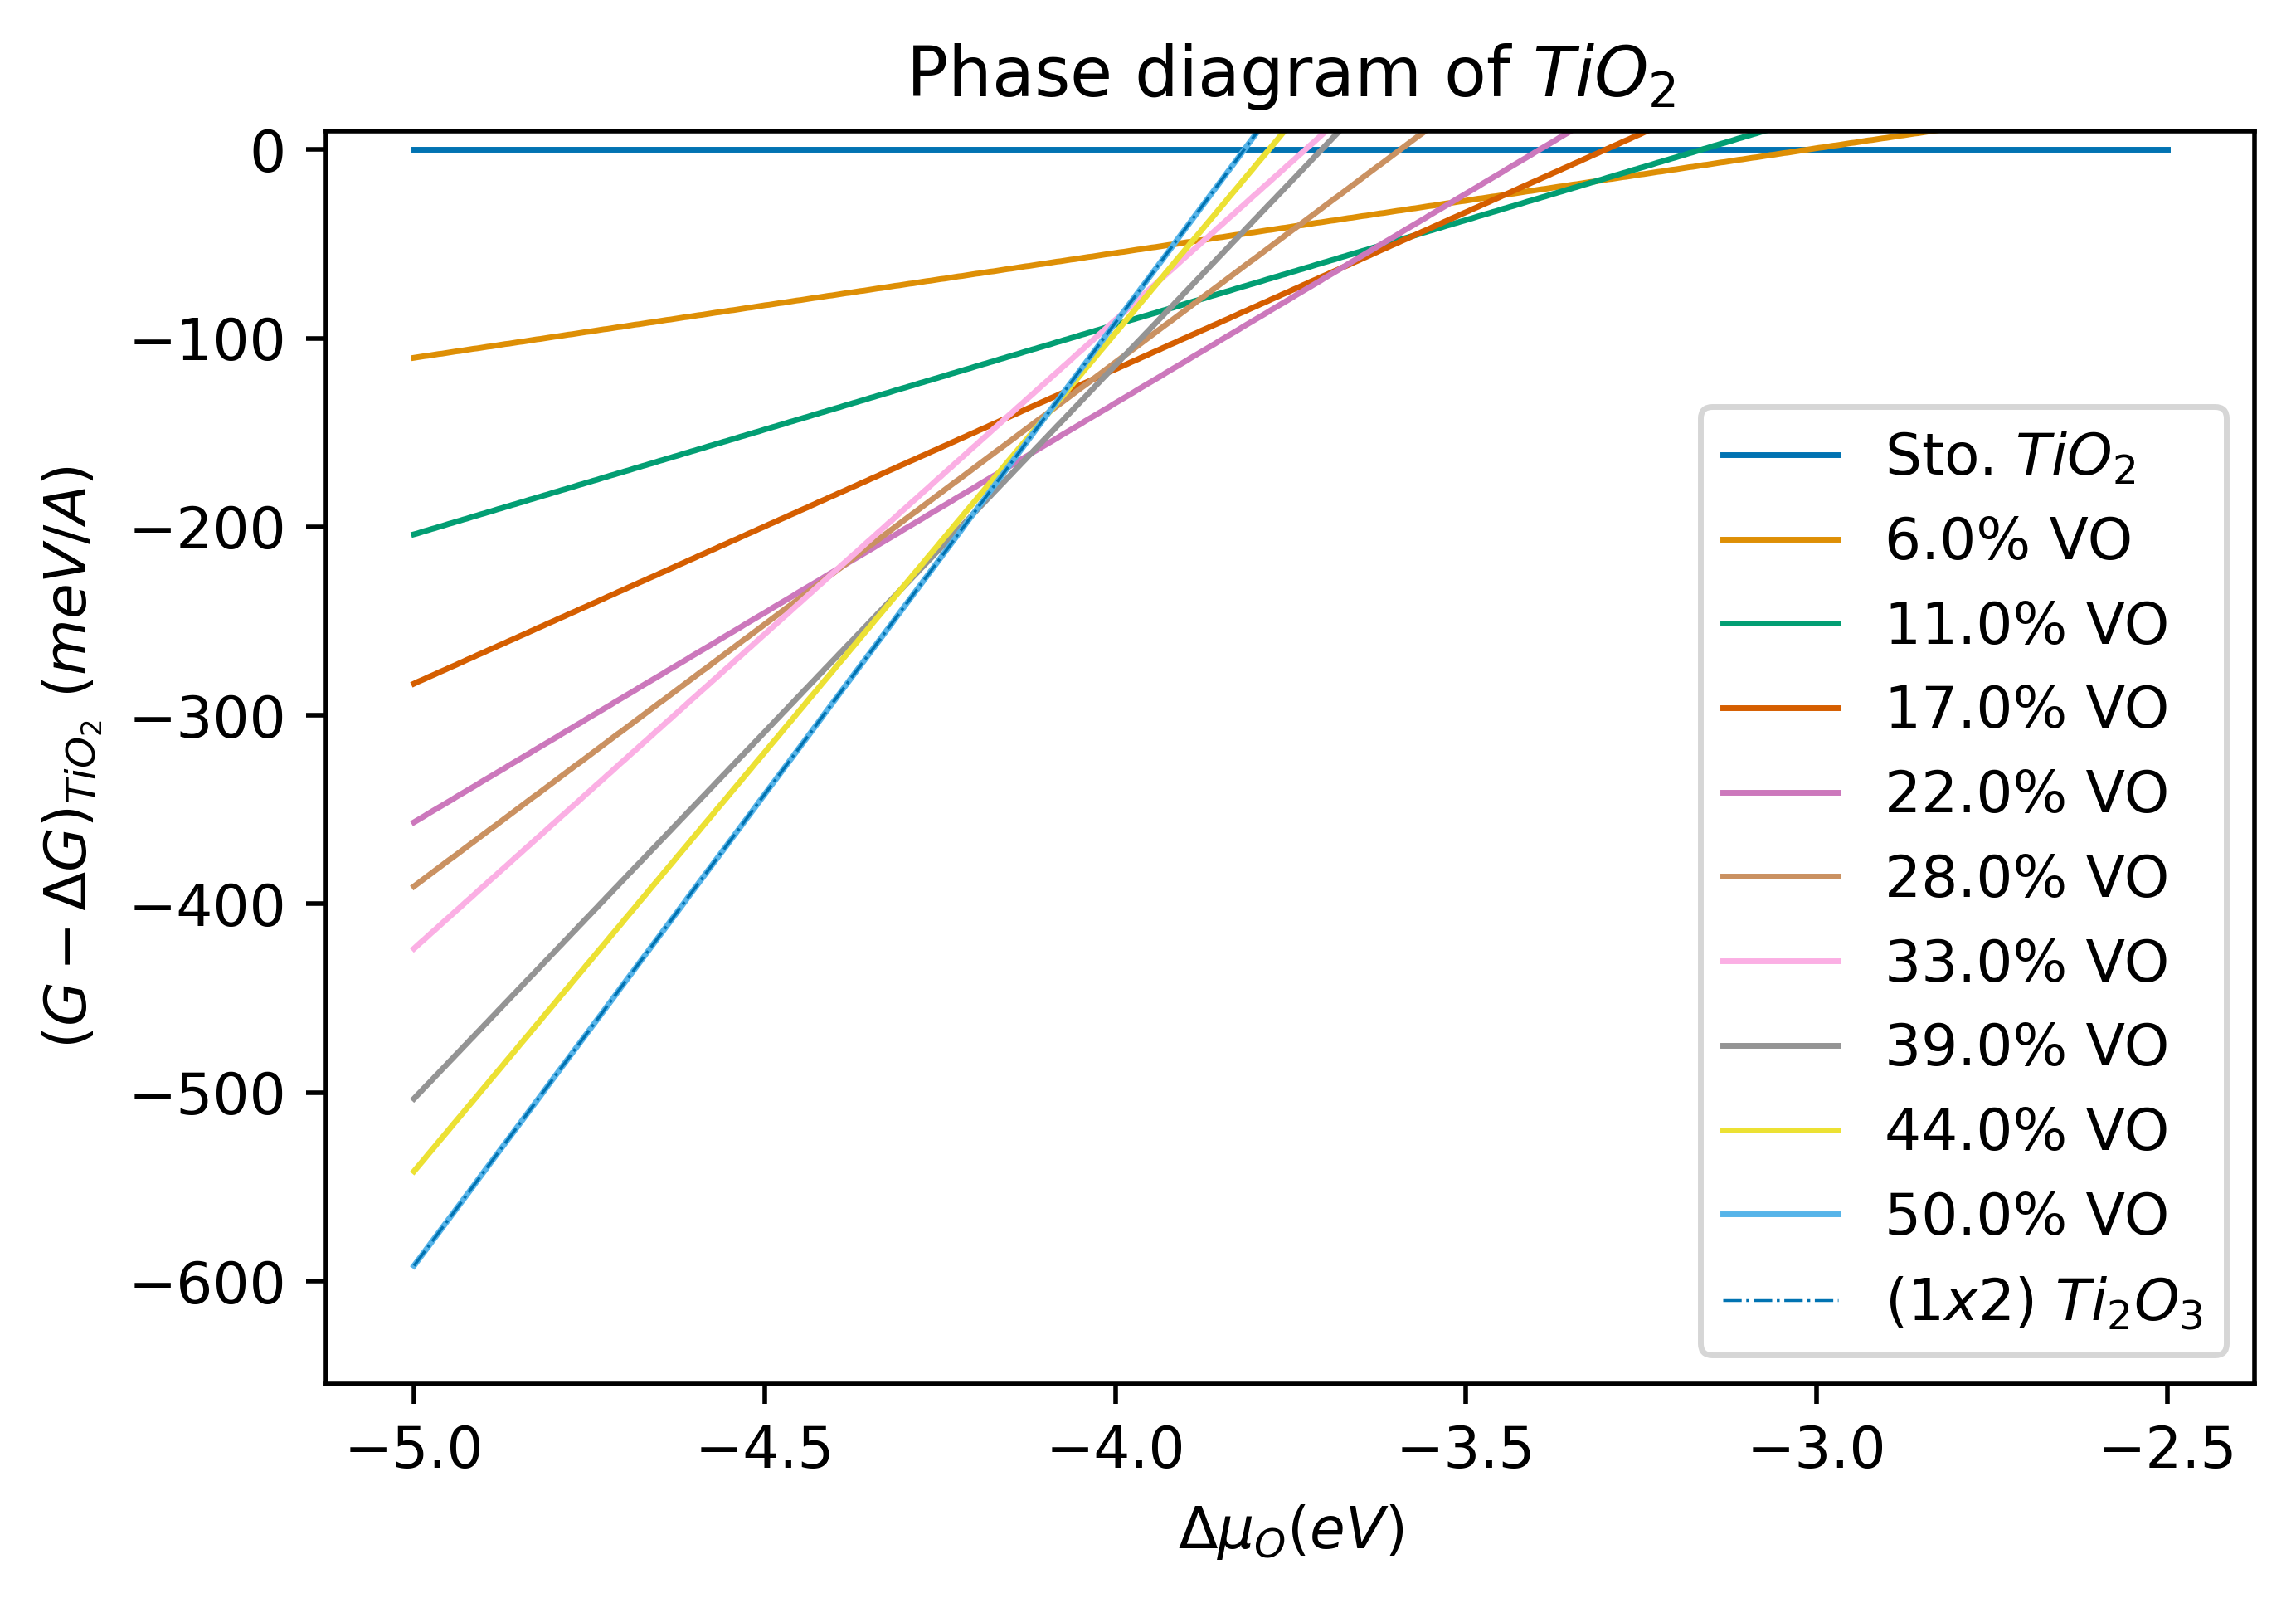

In [7]:
fig, ax = plt.subplots()
colors = iter(sns.color_palette("colorblind", 11).as_hex())
fig.figsize = (12, 12)
for n_vo, data in surfens.items():
    data = np.asarray(data)
    data -= sto_surfen
    data = data * 1000
    if n_vo == 'recon':
        label, lw, ls = '$(1x2)$ $Ti_2O_3$', 0.5, '-.'
    else:
        label, lw, ls = 'Sto. $TiO_2$' if n_vo == 0 else f'{np.round(100 * n_vo / 18)}% VO', 1, '-'

    ax.plot(mu_o_arr, data, label=f"{label}", linewidth=lw, linestyle=ls, c=next(colors))
ax.set_ylim(top=10.0)
ax.set_ylabel("$(G-\\Delta G)_{TiO_2}$ $(meV/A)$")
ax.set_xlabel("$\\Delta\\mu_O(eV)$")
ax.set_title("Phase diagram of $TiO_2$")
ax.legend()
plt.show()

Since the reconstruction coincides exactly with $50\% VO$, we can conclude that the transition from $(1x1) TiO_2$ to the reconstructed surface occurs at $50\% VO$, so the last $(1x1) TiO_2$ we see is with $44\% VO$.

In the lecture notes, this happens in the delocalized case, since the lower surface energies of the reconstruction are only attainable in the localized case.

In order to find the energy difference needed to make the $(1x2)$$Ti_2O_3$ reconstruction more stable than $(1x1) TiO_2$ with 4 VO, we need to find the intersection of the lines with 3 VO and 4 VO first.

Let's invert the surface energy array so that we instead of having arrays for each VO, we have arrays for each $\Delta\mu_O$, and then get the minimum value for each $\Delta\mu_O$ after also shifting by the stoichiometric surface energy.

In [23]:
surfens_by_mu = {mu: {k: v[index] - sto_surfen for k, v in surfens.items()} for index, mu in enumerate(mu_o_arr)}
surfens_by_mu = {k: (min(v, key=v.get), min(v.values())) for k, v in surfens_by_mu.items()}
ls_vo = set([a[0] for a in surfens_by_mu.values()])
line_segments = {a: [] for a in ls_vo}
for k, v in surfens_by_mu.items():
    


{0, 1, 2, 3, 4, 7, 9}

In [9]:
vo3, vo4 = np.asarray(surfens[3]), np.asarray(surfens[4])
intersect1 = np.argwhere(np.diff(np.sign(vo4 - vo3))).flatten()
print(f"The intersection happens on the {intersect1[0]}th array element")

The intersection happens on the 264th array element


So, the intersection happens on the 264th element of $\Delta\mu_O$ array, and the corresponding energy is easily  (by also shifting by the energy of the stoichiometric surface and converting to meV, since we only did those in the plotting part);

In [10]:
intersect1 = 1000 * (vo3[intersect1[0]] - sto_surfen)
print(f'The energy for the transition between VO = 3 and VO = 4 is {intersect1}')

The energy for the transition between VO = 3 and VO = 4 is -62.699999999999974


Final piece of the puzzle is the intersection of $(1x2)$$Ti_2O_3$ reconstruction with the line for VO = 7 (39%), since the transitions seems to be from VO = 7 to the reconstructed surface, looking at the graph, and this intersection is;

In [11]:
vo8, recon = np.asarray(surfens[7]), np.asarray(surfens['recon'])
intersect2 = np.argwhere(np.diff(np.sign(recon - vo8))).flatten()
intersect2 = 1000 * (vo8[intersect2[0]] - sto_surfen)
print(f'The energy for the transition between VO = 8 and reconstructed surface is {intersect2}')

The energy for the transition between VO = 8 and reconstructed surface is -193.50000000000023


In [12]:
print(f'The amount of energy required is then simply {np.round(intersect2 - intersect1, 4)} meV')

The amount of energy required is then simply -130.8 meV


Just for good measure, let's add the lines corresponding to these intersections to our plot.

In [13]:
ax.axhline(y=intersect1, lw=0.5, color='g', linestyle='--')
ax.axhline(y=intersect2, lw=0.5, color='g', linestyle='--')

In [14]:
plt.show()